Apply a trained model to test data

# Setup

In [1]:
import os
import sys
import time
import numpy as np
import h5py
import torch
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
from pytorch_lightning.callbacks.model_summary import ModelSummary
from collections import namedtuple
import xarray
sys.path.append('../')
from cygnssnet import ImageNet, DenseNet, CyGNSSNet, CyGNSSDataModule#, CyGNSSDataset
import utils.mathematics as mat

/home/frauke/anaconda3/envs/cygnss-deploy/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pl.__version__

'1.7.2'

# Load Hyperparameters

In [3]:
path = '../saved_models'
model = 'cygnssnet-epoch=0.ckpt'
checkpoint = torch.load(os.path.join(path, model),
                       map_location=torch.device("cpu"))

In [4]:
checkpoint.keys()

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'callbacks', 'optimizer_states', 'lr_schedulers', 'hparams_name', 'hyper_parameters'])

In [5]:
checkpoint['hyper_parameters'].keys()

dict_keys(['model', 'learning_rate', 'test_batch_size', 'optimizer', 'data', 'v_map', 'v_par', 'v_par_eval', 'v_par_eval_2d', 'log_v_par', 'n_quantiles', 'early_stopping', 'patience', 'verbose', 'nni', 'save_model_path', 'prediction_output_path', 'load_model_path', 'logger', 'checkpoint_callback', 'enable_checkpointing', 'default_root_dir', 'gradient_clip_val', 'gradient_clip_algorithm', 'process_position', 'num_nodes', 'num_processes', 'devices', 'gpus', 'auto_select_gpus', 'tpu_cores', 'ipus', 'log_gpu_memory', 'progress_bar_refresh_rate', 'enable_progress_bar', 'overfit_batches', 'track_grad_norm', 'check_val_every_n_epoch', 'fast_dev_run', 'accumulate_grad_batches', 'max_epochs', 'min_epochs', 'max_steps', 'min_steps', 'max_time', 'limit_train_batches', 'limit_val_batches', 'limit_test_batches', 'limit_predict_batches', 'val_check_interval', 'flush_logs_every_n_steps', 'log_every_n_steps', 'accelerator', 'strategy', 'sync_batchnorm', 'precision', 'enable_model_summary', 'weights_su

In [6]:
# change data path
checkpoint['hyper_parameters']["data"]='../data'
checkpoint['hyper_parameters']["data"]

'../data'

In [7]:
args = namedtuple("ObjectName", checkpoint['hyper_parameters'].keys())(*checkpoint['hyper_parameters'].values())

In [8]:
args

ObjectName(model='cnn', learning_rate=0.001, test_batch_size=64, optimizer='adam', data='../data', v_map=['brcs', 'eff_scatter', 'power_analog', 'raw_counts'], v_par=['ddm_nbrcs', 'ddm_les', 'gps_eirp', 'lna_temp_nadir_port', 'lna_temp_nadir_starboard', 'lna_temp_zenith', 'sc_roll', 'sc_yaw', 'sp_az_body', 'sp_az_orbit', 'sp_rx_gain', 'sp_theta_body', 'tx_pos_x', 'tx_pos_y', 'tx_pos_z', 'tx_vel_x', 'tx_vel_y', 'tx_vel_z', 'zenith_sig_i2q2', 'ddm_snr', 'gps_off_boresight_angle_deg', 'rx_clk_bias_rate', 'sp_ddmi_dopp'], v_par_eval=['GPM_precipitation', 'ddm_ant', 'ddm_brcs_uncert', 'ddm_les', 'ddm_nbrcs', 'ddm_snr', 'ddm_timestamp_unix', 'ddm_timestamp_utc', 'gps_eirp', 'les_scatter_area_log10', 'lna_temp_nadir_port', 'lna_temp_nadir_starboard', 'lna_temp_zenith', 'nbrcs_scatter_area_log10', 'rx_to_sp_range_log10', 'samples_in_sequence', 'sc_alt', 'sc_lat', 'sc_lon', 'sc_pitch', 'sc_roll', 'sc_velocity', 'sc_yaw', 'sp_alt', 'sp_az_orbit', 'sp_inc_angle', 'sp_lat', 'sp_lon', 'sp_rx_gain',

In [9]:
args.data

'../data'

# Load the Data

In [10]:
data_path = "../data"
h5_file = h5py.File(os.path.join(data_path, 'test_data.h5'), 'r', rdcc_nbytes=0)

In [11]:
for key in h5_file.keys():
    print(key)

ERA5_mdts
ERA5_mdww
ERA5_p140121
ERA5_p140124
ERA5_p140127
ERA5_shts
ERA5_shww
ERA5_swh
GPM_precipitation
att_timestamp_utc
brcs
brcs_ddm_peak_bin_delay_row
brcs_ddm_peak_bin_dopp_col
brcs_ddm_sp_bin_delay_row
brcs_ddm_sp_bin_dopp_col
ddm
ddm_ant
ddm_brcs_uncert
ddm_les
ddm_nbrcs
ddm_nbrcs_exceeds_alpha_0.025
ddm_nbrcs_exceeds_alpha_0.05
ddm_nbrcs_exceeds_alpha_0.95
ddm_nbrcs_exceeds_alpha_0.975
ddm_noise_floor
ddm_snr
ddm_timestamp_unix
ddm_timestamp_utc
eff_scatter
gps_ant_gain_db_i
gps_eirp
gps_off_boresight_angle_deg
gps_tx_power_db_w
inst_gain
les_scatter_area_log10
lna_temp_nadir_port
lna_temp_nadir_starboard
lna_temp_zenith
nbrcs_scatter_area_log10
power_analog
prn_code
prn_fig_of_merit
pvt_timestamp_utc
raw_counts
rx_clk_bias
rx_clk_bias_rate
rx_to_sp_range
rx_to_sp_range_log10
samples_in_sequence
sc_alt
sc_lat
sc_lon
sc_pitch
sc_roll
sc_velocity
sc_yaw
sp_alt
sp_az_body
sp_az_orbit
sp_ddmi_dopp
sp_fsw_delay
sp_inc_angle
sp_lat
sp_lon
sp_rx_gain
sp_theta_body
sp_theta_orbit
sp_

In [12]:
h5_file['ddm'][:].shape

(7961,)

In [13]:
y = h5_file['windspeed'][:].astype(np.float32)
y.shape

(7961,)

# Load Model from Checkpoint

In [14]:
checkpoint['hyper_parameters']["model"]

'cnn'

In [15]:
class CyGNSSDataset(Dataset):
    """ Handles everything all Datasets of the different Model have in common like loading the same data files."""
    def __init__(self, flag, args):
        '''
        Load data and apply transforms during setup

        Parameters:
        -----------
        flag : string
            Any of train / valid / test. Defines dataset.
        args : argparse Namespace
            arguments passed to the main script
        -----------
        Returns: dataset
        '''
        self.args=args
        self.h5_file = h5py.File(os.path.join(args.data, flag + '_data.h5'), 'r', rdcc_nbytes=0)  # disable cache
        # load everything into memory
        print(f'\ntimestamp of {flag} data: {self.h5_file.attrs["timestamp"]}')
        start_time = time.time()
        print(f'loading {flag} data into memory...', end='\r')
        
        self.v_par_all_names = self.args.v_par + self.args.v_par_eval

        # load labels
        self.y = self.h5_file['windspeed'][:].astype(np.float32)

        # normalize main input data
        # Save normalization values together with the trained model
        # For inference load the normalization values

        if flag=='train': # determine normalization values
            self.args.normalization_values = dict()
        
        print(f'\nnormalizing {flag} data')
        # stack map vars (2D vars)
        self.X = []
        for v_map in self.args.v_map:
            X_v_map = self.h5_file[v_map][:].astype(np.float32)
            if flag=='train':
                norm_vals = dict()
                X_v_map, X_mean, X_std = mat.standard_scale(X_v_map, return_params=True)
                self.args.normalization_values[f'{v_map}_mean'] = X_mean
                self.args.normalization_values[f'{v_map}_std']  = X_std
            else:
                X_mean = self.args.normalization_values[f'{v_map}_mean']
                X_std = self.args.normalization_values[f'{v_map}_std']
                X_v_map = mat.standard_scale(X_v_map, mean=X_mean, scale=X_std)
                
            self.X.append(X_v_map) # append scaled 2D map
            print(f'* {v_map} after normalization: mean={np.mean(X_v_map):.2e} / std = {np.std(X_v_map):.2e}')
        self.X = np.stack(self.X, axis=1)
       # stack additional vars
        # load all vars first
        self.v_par_all = [self.h5_file[par][:] for par in self.v_par_all_names]
        n_v_par = len(self.args.v_par)
        if n_v_par > 0:
            # only normalize input vars
            for i, par in enumerate(self.v_par_all[:n_v_par]):
                key = self.v_par_all_names[i]
                # additional log transform
                if key in self.args.log_v_par:
                    print(f'* {key} is log-transformed before normalization')
                    par = mat.log_transform(par)
                if flag=='train':
                    self.v_par_all[i], v_mean, v_std = mat.standard_scale(par, return_params=True) 
                    self.args.normalization_values[f'{key}_mean'] = v_mean
                    self.args.normalization_values[f'{key}_std'] = v_std
                else:
                    v_mean = self.args.normalization_values[f'{key}_mean']
                    v_std = self.args.normalization_values[f'{key}_std']
                    self.v_par_all[i] = mat.standard_scale(par, mean=v_mean, scale=v_std)
                tm = np.mean(self.v_par_all[i]) # true mean
                ts = np.std(self.v_par_all[i]) # true std
                print(f'* {key} after normalization: mean={tm:.2e} / std = {ts:.2e}')
            self.v_par = np.stack(self.v_par_all[:n_v_par], axis=1)
        else:
            self.v_par = []
        if self.args.v_par_eval:
            self.v_par_eval = np.stack(self.v_par_all[n_v_par:], axis=1)
        else:
            self.v_par_eval = []

        # additional reduction of the data set
        if self.args.min_samples_in_sequence > 1:
            col_idx = self.args.v_par_eval.index('samples_in_sequence')
            mask = self.v_par_eval[:, col_idx] >= self.args.min_samples_in_sequence
            mask = mask.astype(bool)
            self._filter_all_data_by_mask(mask, flag, 'min_samples_in_sequence')
        if self.args.min_wind_speed > 0:
            col_idx = self.args.v_par_eval.index('windspeed')
            mask = self.v_par_eval[:, col_idx] >= self.args.min_wind_speed
            mask = mask.astype(bool)
            self._filter_all_data_by_mask(mask, flag, 'min_wind_speed')
        if flag=='train' and self.args.train_days < np.inf:
            col_idx = self.args.v_par_eval.index('ddm_timestamp_unix')
            daystamp = self.v_par_eval[:, col_idx]
            daystamp = (daystamp - np.min(daystamp)) / 24 / 3600
            # select all samples with days within (dmax - train_days)
            mask = daystamp >= np.max(daystamp) - self.args.train_days
            print(daystamp[mask])
            self._filter_all_data_by_mask(mask, flag, 'train_days')
        if self.args.confidence_interval_bottom:
            col_idx = self.args.v_par_eval.index(self.args.confidence_interval_bottom)
            col_idx = self.args.v_par_eval.index(self.args.confidence_interval_bottom)
            mask = self.v_par_eval[:, col_idx].astype(bool)
            self._filter_all_data_by_mask(mask, flag, \
                'confidence interval (bottom) ' + self.args.confidence_interval_bottom)
        if self.args.confidence_interval_top:
            col_idx = self.args.v_par_eval.index(self.args.confidence_interval_top)
            col_idx = self.args.v_par_eval.index(self.args.confidence_interval_top)
            mask = self.v_par_eval[:, col_idx].astype(bool)
            mask = ~mask # *exclude* the samples exceeding the top confidence interval
            self._filter_all_data_by_mask(mask, flag, \
                'confidence interval (top) ' + self.args.confidence_interval_top)
        if self.args.accept_reject:
            if flag=='train':
                alpha = self.args.accept_reject[0]
                window = int(self.args.accept_reject[1])
                mask = cutils.accept_reject(self.y, alpha, window)
                self._filter_all_data_by_mask(mask, flag, 'accept reject')
        if self.args.transform_target: # careful to transform only after cutting confidence intervals!
            print('Power transform with scale = ', self.args.transform_target_scale)
            y_tmp = mat.power_transform(self.y, self.args.transform_target_scale)
            self.y = y_tmp

            self.y -= self.args.transform_target_mean
            self.y /= self.args.transform_target_std
            print('Transformed target:')
            print('Mean', np.mean(self.y))
            print('Std', np.std(self.y))

        print(f'loading and transforming all {flag} data in memory took {time.time() - start_time:.2f}s')
        print(f'{flag} input data: {self.X.shape} ({self.X.nbytes // 1e6}MB)')
        print(f'{flag} labels: {self.y.shape} ({self.y.nbytes // 1e6}MB)')

    def _filter_all_data_by_mask(self, mask, flag, name=''):
        self.X, self.y = self.X[mask], self.y[mask]
        if len(self.v_par) > 0:
            self.v_par = self.v_par[mask]
        if len(self.v_par_eval) > 0:
            self.v_par_eval = self.v_par_eval[mask]
        print(f'{flag} input data after {name} downsampling: {self.X.shape} ({self.X.nbytes // 1e6}MB)')

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        X = self.X[idx]
        if len(self.v_par) > 0:
            X = (X, self.v_par[idx])
        y = self.y[idx]
#        if self.args.auxiliary_loss_rain:
#            y_aux = self.v_par_eval[idx, self.args.v_par_eval.index('GPM_precipitation')]
#            y = (y, y_aux)
        return (X, y)


In [16]:
CyGNSSDataset('test', args)


timestamp of test data: 2021-10-19 09:45:33.788647
loading test data into memory...
normalizing test data
* brcs after normalization: mean=1.91e-01 / std = 1.27e+00
* eff_scatter after normalization: mean=1.69e-01 / std = 1.28e+00
* power_analog after normalization: mean=-1.82e-01 / std = 6.05e-01
* raw_counts after normalization: mean=-3.20e-01 / std = 5.89e-01
* ddm_nbrcs after normalization: mean=2.08e-01 / std = 9.65e-01
* ddm_les after normalization: mean=2.13e-01 / std = 9.04e-01
* gps_eirp after normalization: mean=-5.66e-01 / std = 4.81e-01
* lna_temp_nadir_port after normalization: mean=1.70e+00 / std = 6.44e-01
* lna_temp_nadir_starboard after normalization: mean=1.45e+00 / std = 6.16e-01
* lna_temp_zenith after normalization: mean=1.04e+00 / std = 8.77e-01
* sc_roll after normalization: mean=-5.86e-01 / std = 5.58e-02
* sc_yaw after normalization: mean=-1.50e+00 / std = 2.49e+00
* sp_az_body after normalization: mean=-2.05e-01 / std = 9.20e-01
* sp_az_orbit after normalizat

In [17]:
class CyGNSSDataModule(pl.LightningDataModule):
    """ Lightning data module for CyGNSS data """

    def __init__(self, args):
        super().__init__()
        self.args = args

    def prepare_data(self, args):
        '''Use this method to do things that might write to disk or that need to be done 
        only from a single process in distributed settings.'''
        pass

    def setup(self, stage = None):
        '''
        Data operations performed on every GPU

        setup() expects an stage: Optional[str] argument. It is used to separate setup logic 
        for trainer.{fit,validate,test}. If setup is called with stage = None, we assume all 
        stages have been set-up.

        Creates self.{train_data, valid_data, test_data} depending on 'stage' (CyGNSSDataset)
        '''

        if stage in (None, 'fit'):
            self.train_data = CyGNSSDataset('train', self.args)
            self.valid_data = CyGNSSDataset('valid', self.args)
        if stage in (None, 'test'):
            self.test_data = CyGNSSDataset('test', self.args)

    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.args.batch_size, 
                          num_workers=self.args.num_workers, shuffle=True, drop_last=True)

    def val_dataloader(self):
        return DataLoader(self.valid_data, batch_size=self.args.test_batch_size, 
                          num_workers=self.args.num_workers, shuffle=False, drop_last=False)

    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=self.args.test_batch_size, 
                          num_workers=self.args.num_workers, shuffle=False, drop_last=False)

    def predict_dataloader(self, args): # predicts on test set
        return DataLoader(self.test_data, batch_size=self.args.test_batch_size, 
                          num_workers=self.args.num_workers, shuffle=False, drop_last=False)

    def get_input_shapes(self, stage = None):
        if stage in (None, 'fit'):
            shape_data = self.train_data
        if stage == 'test':
            shape_data = self.test_data 


        if isinstance(shape_data[0][0], tuple):
            input_shapes = tuple(input_.shape for input_ in shape_data[0][0])
        else:
            input_shapes = shape_data[0][0].shape,
        return input_shapes

    @staticmethod
    def add_dataloader_specific_args(parent_parser):
        parser = argparse.ArgumentParser(parents=[parent_parser], add_help=False)
        parser.add_argument('--log-transform-rain', action='store_true')
        parser.add_argument('--transform-target', action='store_true', 
                            help='Transform labels to normal distribution (experimental)')
        parser.add_argument('--confidence-interval-bottom', type=str, default='',
                            help='remove all samples below this threshold')
        parser.add_argument('--confidence-interval-top', type=str, default='',
                            help='remove all samples above this threshold')
        parser.add_argument('--min-wind-speed', type=float, default=0.0)
        parser.add_argument('--train-days', type=float, default=np.inf)
        parser.add_argument('--min-samples-in-sequence', type=int, default=1, 
                            help='Minimum samples for sequence to be considered in averaged dataset.')
        parser.add_argument('--num-workers', type=int, default=1, help='dataloader processes')
        parser.add_argument('--accept-reject', type=float, nargs=2, 
                            help='alpha+window for gfz_202003.utils.cygnss_utils.accept_reject') 
        return parser

    def print_all_quantile_losses(self, y_pred, dataloader):
        def print_quantile_losses(name, losses, quantiles):
            quantile_losses_str = ', '.join([f'{l:.2f}' for l in losses])
            quantiles_str = ', '.join([f'{q:.2f}' for q in quantiles])
            print(f'\nlosses by {name} quantile: {quantile_losses_str}\nwith quantiles: {quantiles_str}')

        def print_quantile_losses_2d(name1, name2, losses, quantiles1, quantiles2, sizes):
            print(f'\n2d quantile losses for {name1}+{name2} (rows are per quantile of {name1}):')
            for loss_row in losses:
                print(', '.join([f'{l:.2f}' for l in loss_row]))
            print('\nwith sizes:')
            for size_row in sizes:
                print(', '.join([f'{s}' for s in size_row]))
            print()
            quantiles_strs = [', '.join([f'{q:.2f}' for q in quantiles]) for quantiles in [quantiles1, quantiles2]]
            print(f'with {name1} quantiles: {quantiles_strs[0]}')
            print(f'with {name2} quantiles: {quantiles_strs[1]}')
            print()

        y_true = dataloader.dataset.y

        print(f'Note: quantile losses always report MSE. Loss_fn was {self.args.loss}\n')


        quantile_losses, quantiles = mat.losses_by_quantiles(y_true, y_true, y_pred, self.args.n_quantiles)
        print_quantile_losses('y_true', quantile_losses, quantiles)

        for v_par in self.args.v_par_eval:
            col_idx = self.args.v_par_eval.index(v_par)
            arr = dataloader.dataset.v_par_eval[:, col_idx]
            quantile_losses, quantiles = mat.losses_by_quantiles(arr, y_true, y_pred,
                                                                 self.args.n_quantiles)
            print_quantile_losses(v_par, quantile_losses, quantiles)

        for v_par_2d in self.args.v_par_eval_2d:
            names = v_par_2d.split('+')
            col_idxs = [self.args.v_par_eval.index(name) for name in names]
            arrs = [dataloader.dataset.v_par_eval[:, col_idx] for col_idx in col_idxs]
            if 'GPM_precipitation' in names:
                # filter samples with rain > 0 if given
                mask = arrs[names.index('GPM_precipitation')] > 0.0
                arr1, arr2 = [arr[mask] for arr in arrs]
                y_true, y_pred = y_true[mask], y_pred[mask]
            quantile_losses, quantiles1, quantiles2, sizes = mat.losses_by_quantiles_2d(arr1, arr2, y_true, y_pred, 10)
            print_quantile_losses_2d(names[0], names[1], quantile_losses, quantiles1, quantiles2, sizes)


In [18]:
cdm = CyGNSSDataModule(args)
cdm.setup(stage='test')
input_shapes = cdm.get_input_shapes(stage='test')


timestamp of test data: 2021-10-19 09:45:33.788647
loading test data into memory...
normalizing test data
* brcs after normalization: mean=1.91e-01 / std = 1.27e+00
* eff_scatter after normalization: mean=1.69e-01 / std = 1.28e+00
* power_analog after normalization: mean=-1.82e-01 / std = 6.05e-01
* raw_counts after normalization: mean=-3.20e-01 / std = 5.89e-01
* ddm_nbrcs after normalization: mean=2.08e-01 / std = 9.65e-01
* ddm_les after normalization: mean=2.13e-01 / std = 9.04e-01
* gps_eirp after normalization: mean=-5.66e-01 / std = 4.81e-01
* lna_temp_nadir_port after normalization: mean=1.70e+00 / std = 6.44e-01
* lna_temp_nadir_starboard after normalization: mean=1.45e+00 / std = 6.16e-01
* lna_temp_zenith after normalization: mean=1.04e+00 / std = 8.77e-01
* sc_roll after normalization: mean=-5.86e-01 / std = 5.58e-02
* sc_yaw after normalization: mean=-1.50e+00 / std = 2.49e+00
* sp_az_body after normalization: mean=-2.05e-01 / std = 9.20e-01
* sp_az_orbit after normalizat

In [19]:
if checkpoint['hyper_parameters']["model"]=='cnn':
    backbone = ImageNet(args, input_shapes)
elif checkpoint_args.model=='dense':
    backbone = DenseNet(args, input_shapes)

In [20]:
model = CyGNSSNet.load_from_checkpoint(os.path.join(path, model),
                                      map_location=torch.device("cpu"),
                                      args=args,
                                      backbone=backbone)

In [21]:
model.eval()

CyGNSSNet(
  (backbone): ImageNet(
    (cv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (hidden): ModuleList(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): C

# Apply the Model

In [46]:
test_loader = cdm.test_dataloader()
trainer = pl.Trainer(#weights_summary='full', 
                    #num_sanity_val_steps=0, 
                    #gpus=int(torch.cuda.is_available()),
                    enable_progress_bar=False)

#trainer.test(model=model, test_dataloaders=test_loader)
y_pred = trainer.predict(model=model, dataloaders=[test_loader])
y_pred = torch.cat(y_pred).detach().cpu().numpy().squeeze()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint


In [47]:
y_pred

array([8.03745  , 9.155466 , 6.4046926, ..., 6.3773756, 6.0596523,
       6.4005737], dtype=float32)

In [48]:
y_pred.shape

(7729,)

In [59]:
dataset = CyGNSSDataset('test', args)


timestamp of test data: 2021-10-19 09:45:33.788647
loading test data into memory...
normalizing test data
* brcs after normalization: mean=1.91e-01 / std = 1.27e+00
* eff_scatter after normalization: mean=1.69e-01 / std = 1.28e+00
* power_analog after normalization: mean=-1.82e-01 / std = 6.05e-01
* raw_counts after normalization: mean=-3.20e-01 / std = 5.89e-01
* ddm_nbrcs after normalization: mean=2.08e-01 / std = 9.65e-01
* ddm_les after normalization: mean=2.13e-01 / std = 9.04e-01
* gps_eirp after normalization: mean=-5.66e-01 / std = 4.81e-01
* lna_temp_nadir_port after normalization: mean=1.70e+00 / std = 6.44e-01
* lna_temp_nadir_starboard after normalization: mean=1.45e+00 / std = 6.16e-01
* lna_temp_zenith after normalization: mean=1.04e+00 / std = 8.77e-01
* sc_roll after normalization: mean=-5.86e-01 / std = 5.58e-02
* sc_yaw after normalization: mean=-1.50e+00 / std = 2.49e+00
* sp_az_body after normalization: mean=-2.05e-01 / std = 9.20e-01
* sp_az_orbit after normalizat

In [76]:
y = dataset.y

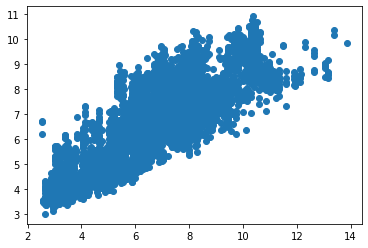

In [78]:
import matplotlib.pyplot as plt

plt.scatter(y, y_pred);

# Save to Database

In [120]:
import sqlite3
from sqlite3 import Error

In [153]:
def create_connection(path):
    '''
    sqlite3.connect(path) returns a connection object, which is in turn returned by create_connection(). 
    This connection object can be used to execute queries on an SQLite database.
    '''
    connection = None
    try:
        # If the database exists at the specified location (path), then a connection to the database is established.
        connection = sqlite3.connect(path)
        print("Connection to SQLite DB succesful")
    except Error as e:
        print(f"The error '{e}' occured")

    return connection

In [154]:
connection = create_connection("../cycnss_test_frauke.sqlite")
cursor = connection.cursor()

Connection to SQLite DB succesful


In [155]:
create_users_table = """
CREATE TABLE IF NOT EXISTS windspeed_pred (
  id INTEGER PRIMARY KEY AUTOINCREMENT,
  windspeed REAL
);
"""
cursor.execute(create_users_table)  
connection.commit()

In [156]:
y_pred[0]

8.03745

In [157]:
cursor.execute("INSERT INTO windspeed_pred (windspeed) VALUES (?);", (float(y_pred[0]),)) 
connection.commit()

In [158]:
read_data = """SELECT * FROM windspeed_pred"""
cursor = connection.cursor()
result = cursor.execute(read_data)

In [159]:
result.fetchall()

[(1, 8.037449836730957)]

In [ ]:
# Wich columns should be in the database?